In [3]:
%%capture hide_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

import markov_with_syllables as markov
from syllablizer import syllablize
from analysis import analyze_markov_syllables as analyze
from get_text import get_texts
from tfidf import num_nonzero_tokens
import plotter

# Expanding English: Markov Generated Words
*By Ben Morris and CJ Hilty*

## Intro
Syllables are the basic unit of spoken English. They can be rearranged extensively and can still result in a word, but with a completely different meaning. **Alloy** is one example. switching the order of its syllables leaves us with **loyal**, which has a completely different meaning, even though the syllables are identical.

As a group, we’re fascinated by syllables and how they make building words in English possible. While the presence of syllables determines if a word is *valid*, the *order* of syllables determines the meaning the word. After learning about **discrete markov-chain generation** with words, we were both interested in exploring the same concepts with syllables. Can a basic generator algorithm find patterns that make convincing english words? Or would the words be clearly random? Our guiding question is: **Do syllables in the English language follow a pattern that can be reproduced by a computer?**

## Methodology
### Overview
Our plan to answer this question was to create a **discrete-chain Markov generator**, like we did in Assignment 2, but modify it so that it takes syllables as the base unit instead of words. This way, we can combine these syllables to create new words, in much the same way our previous Markov generator combined words to make new sentences. Therefore, our workflow looked like this:


Figure 1: Overview of workflow to
generate new English words


### Data Sources
Our first step was to find some corpora. While we were initially going to use Wikipedia articles, we decided that they might be too short for our purposes, so we opted for books instead. We made a list of a small sampling of important works over time, and used `urllib` to download each of these as `.txt` files and convert them to `string`s.

* The Iliad ([Project Gutenberg](https://www.gutenberg.org/))
* Romeo and Juliet ([Project Gutenberg](https://www.gutenberg.org/))
* The Canterbury Tales ([Project Gutenberg](https://www.gutenberg.org/))
* The Great Gatsby ([Project Gutenberg](https://www.gutenberg.org/))
* Monty Python and the Holy Grail ([Teropa's NLP GitHub](https://github.com/teropa/nlp/tree/master/resources/corpora/webtext))
* Finnegan's Wake ([archive.org](https://archive.org))

While some of these works, such as Monty Python and Finnegan’s Wake, were chosen mostly for fun, we felt the rest of these provided a good sampling of the English language over time, giving us a variety of options to work with.

### Syllablizer
To split text into syllables, we made our own custom syllablizer, based off the rules at [this link](). We implemented this recursively, so we effectively only needed to find the first syllable. From there, we split before a consonant if there is only one, or between two consonants if there were two that were not a consonant pair, such as sh, wh, or ck. If all that is remaining to the right of the split are consonants, then it appends it to the end of the current syllable. Some example output is shown below.

In [6]:
print(syllablize("item"))
print(syllablize("should"))
print(syllablize("backpack"))
print(syllablize("supercalifragilisticexpialidocious"))

['i', 'tem']
['should']
['back', 'pack']
['su', 'per', 'ca', 'lif', 'ra', 'gi', 'lis', 'ti', 'cex', 'pia', 'li', 'do', 'cious']


While this method is not the best one out there, and is certainly far from perfect, we figured it was good enough for our purposes, and hoped that any remaining issues would be solved through the Markov generator, as the syllables will be thrown back together anyways.

To process the corpora for the Markov generator, we first removed any tokens that contained numbers, no lowercase letters (which we took as abbreviations), then pruned the remaining words to only contain letters. From here, we syllablized each word and gave the Markov generator a 2-D list, where each sublist represents a word and each element, a syllable. Note that the generator ignores one- and two-letter words.

In [11]:
print(markov.build_syllable_list("This is an example sentence."))

[['this'], ['e', 'xam', 'ple'], ['sen', 'ten', 'ce']]


### Markov Chain
Given this list of syllables, we were able to construct a dictionary, mapping each syllable to all syllables that followed it, preserving frequency.

In [12]:
example_dict = markov.build_next_syllables("We almost always chose video games when allowed.")
print(example_dict)

{'': ['al', 'al', 'chose', 'vi', 'ga', 'when', 'al'], 'al': ['most', 'ways', 'lo'], 'most': [''], 'ways': [''], 'chose': [''], 'vi': ['deo'], 'deo': [''], 'ga': ['mes'], 'mes': [''], 'when': [''], 'lo': ['wed'], 'wed': ['']}


The list corresponding to the empty string that starts off the dictionary represents the list of all syllables that start off a word. Any empty string that follows a syllable - i.e. is in the list corresponding to its key - means that that syllable ends a word.

Once calculated, this dictionary can recreate random words from the original corpus, or, once given enough data, can create entirely new words. First, it chooses a random syllable from the list following the empty string - a random syllable that starts off a word. It appends that to the word that it is generated. It then goes to the dictionary entry for that syllable, and randomly chooses a syllable that follows it, appending that to the end of the word. It then looks at the list of syllables that follows the most recent syllable, and repeats the process. If it ever comes upon an empty string as the randomly chosen “syllable”, it ends the word and returns.

Run this code block several times; it will (essentially) print out a random word from the above sentence.

In [13]:
print(markov.generate_word(example_dict))

allowed


Given more data, it is able to produce completely unique words!

In [16]:
# “Finnegan’s Wake” can be replaced with: “Iliad”, “Romeo and Juliet”, “Canterbury Tales”, “Great Gatsby”, or “Monty Python”
corpus = get_texts("Finnegan's Wake")
example_corpus_dict = markov.build_next_syllables(corpus)

In [21]:
print(markov.generate_word(example_corpus_dict))

tronf


## Results
To visualize these results, we ran 10,000 generations on each text in our corpora. After removing repeat words, we split each of the remaining words into 3 categories:

* Repeated Words. These are words that appeared in the given corpus that the Markov generator remade.
* Unseen English Words. These are words that appear in an English dictionary, but *not* in the original corpus. The presence of these words are the key to answer our question; if there are a good number of them, it means our generator can create actual English words that it has not yet seen!
* Unique Words. These are words that appear neither in the original corpus or the English language. Our algorithm completely made up these words.

In [25]:
corpora = get_texts("all")
titles = list(corpora.keys())
texts = list(corpora.values())
print("Downloaded Texts")
analyses = analyze(texts)
num_tokens = num_nonzero_tokens(titles)

Downloaded Texts
Starting Analysis of text 1/6
Starting Analysis of text 2/6
Starting Analysis of text 3/6
Starting Analysis of text 4/6
Starting Analysis of text 5/6
Starting Analysis of text 6/6
Starting TF/IDF of Text 1/6
Starting TF/IDF of Text 2/6
Starting TF/IDF of Text 3/6
Starting TF/IDF of Text 4/6
Starting TF/IDF of Text 5/6
Starting TF/IDF of Text 6/6


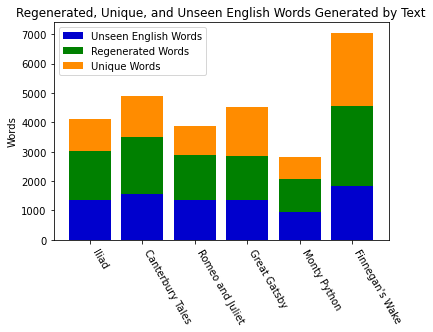

In [27]:
plotter.plot_word_type_frequency(titles, analyses)

All of the texts had around 20% of words (ignoring repeats) be unseen English words! This is great evidence for the pro side - that English is reproducible - as a very large percentage of words that our generator created are English words that it had not seen before. Perhaps the biggest surprise is with Finnegan’s wake - it produced the largest amount of English words, despite containing the least English words of all the texts, as it is a nonsense poem. Though, when compared percentage-wise, as below, it is clear that Finnegan's Wake is actually the lowest (though still quite high!)

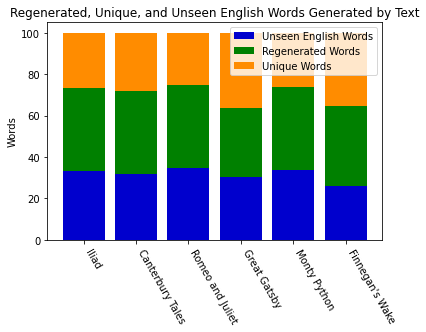

In [28]:
plotter.plot_word_type_frequency(titles, analyses, True)

Next, we looked into the correlation between the number of unique input words. To calculate how many unqiue words each corpus had, we used TF/IDF. The details of this are outside the scope of this essay, but the basic results are such: a word in a corpus has a high TF/IDF if it is common in the corpus but not in the overall corpora. If a word is either not common in the target corpus, or it is common in the target corpus but also in all the corpora (suc as the word "the"), its TF/IDF score is low. We defined the number of unique words as the number of tokens in each text with a nonzero TF/IDF score when compared to our full set of corpora.

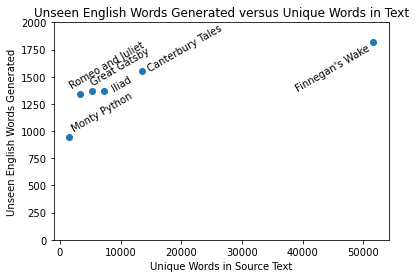

In [29]:
plotter.plot_unseen_vs_tokens(titles, analyses, num_tokens)

While we did not analyze quite enough texts to be able to draw a solid conclusion from this, we can still see the startings of a positive correlation, even including Finnegan's Wake. This would imply that more words would give a better estimation of English, which makes sense.

Finally, we calculated the average word length for each corpus, along with the average word length of the output, which is shown below.

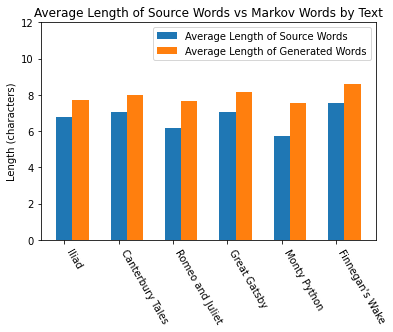

In [30]:
plotter.plot_word_lengths(titles, analyses)

This shows a key difference between "actual" English - our corpora - and generated English from our Markov chain. Words from our Markov chain tend to be larger. So while we still had great success in creating English words, there are still some key differences between generated words and actual English.

## Conclusion

Syllables in the English language can be partially reformed into words by a computer. We were able to recreate English words a resounding 70% percent of the time, and approximately 45% of those words were never-before-seen English words. We cannot at this time recommend any methods of improving our generator that would close this gap between 70% and 100%. A more advanced method of determining what syllable combinations go together may be able to solve this problem, but our implementation of the discrete-chain Markov generator leaves us with around 30% percent error.

### Other closing remarks
Our results may have been partially affected by our imperfect syllable splitter. While our code properly follows the general rules of syllable splitting, we were not able to encompass all the nuances and exceptions of splitting syllables. For this reason, the data we fed into the Markov generator was not perfect.

## Citations
* http://english.glendale.cc.ca.us/syllables.html
* http://www.gutenberg.org/
* https://github.com/teropa/nlp/tree/master/resources/corpora/webtext
* https://archive.org/details/finneganswake00joycuoft/?view=theater
* https://www.bogotobogo.com/python/NLTK/tf_idf_with_scikit-learn_NLTK.php